# Contents of this Notebook
• Quick look at some images in the dataset

• Download a few categories of shape positives and some categories to distinguish those from

• Download the classification text file

• Set some core variables needed throughout

• Load flattened arrays (N, 784) → reshape to (N, 28, 28)

• Organise data into X and y

• Define and compile the model

• Test train split

• Training

• Preview, graphs, refinement

• Saving the model and converting it into a javascript model (tensorflowjs) via terminal commands



In [2]:
from IPython.display import display
from quickdraw import QuickDrawDataGroup
import os, urllib.request
import requests
from keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import json, pathlib
from google.cloud import storage
from dotenv import load_dotenv, dotenv_values

2025-08-27 17:36:42.173963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load your .env file
load_dotenv()

# Resolve full path to service account JSON
key_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
if not key_path:
    raise ValueError("GOOGLE_APPLICATION_CREDENTIALS not set in .env")

key_path = os.path.abspath(os.path.expanduser(key_path))
config = dotenv_values(".env").get('GOOGLE_APPLICATION_CREDENTIALS')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config

TypeError: str expected, not NoneType

In [33]:
np.random.seed(42)

loading circle drawings
load complete


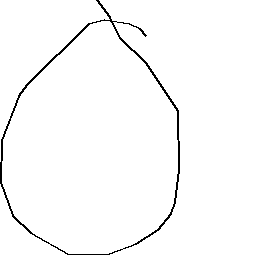

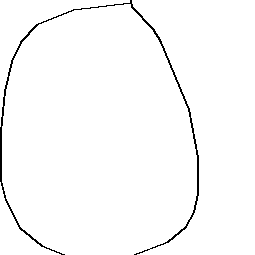

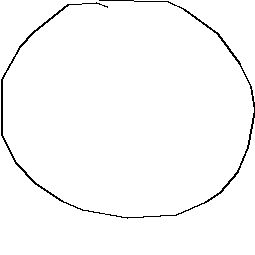

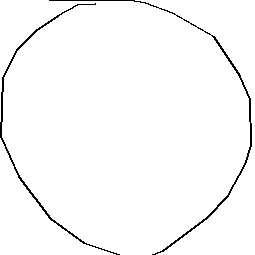

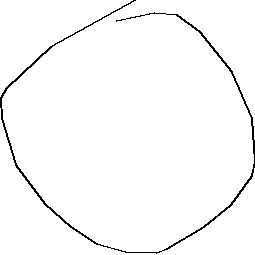

In [34]:
circle_group = QuickDrawDataGroup("circle", max_drawings=10000)

for _ in range(5):
    d = circle_group.get_drawing()
    display(d.image)

In [35]:
DATA_DIR = "data/quickdraw_npy"  # where your .npy files are

TARGETS = ["circle", "square", "triangle", "star", "vertical_line"]
OTHERS  = ["face", "cat", "cloud", "house", "tree"]

CLASS_NAMES = TARGETS + ["other"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}

In [36]:
classes = TARGETS + OTHERS

In [78]:
# Assumes you've already authenticated using your .env and service account key
# and set GOOGLE_APPLICATION_CREDENTIALS properly before this code runs

bucket_name = "doodle-autocomplete"
prefix = "training-data"

# Make the data directory if you don't have it
os.makedirs(DATA_DIR, exist_ok=True)

# Create GCS client
client = storage.Client()
bucket = client.bucket(bucket_name)

for c in classes:
    blob_path = f"{prefix}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")

    if not os.path.exists(dst):
        print(f"Downloading {blob_path} from GCS...")
        blob = bucket.blob(blob_path)
        blob.download_to_filename(dst)

print("Done ✅")

Done ✅


In [37]:
os.makedirs(DATA_DIR, exist_ok=True) #make the data directory if you don't have it on your machine

base = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"

for c in classes:
    url = f"{base}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")
    if not os.path.exists(dst):
        print("downloading", url)
        urllib.request.urlretrieve(url, dst)
print("done")

done


# 1. About the data - What Google did with QuickDraw

Each QuickDraw doodle was drawn by a person as a sequence of strokes (vector data).

Google rasterised those strokes into 28 × 28 pixel images, grayscale.

Each pixel is **grayscale** — it holds an intensity value from 0 to 255 (0 = black, 255 = white, or sometimes inverted depending on convention).

To make the dataset compact, they then flattened each 28×28 image into a 1D vector of length 784 (because 28 × 28 = 784).

In [38]:
def load_npy(path, limit=None):
    """
    Quick, Draw! numpy_bitmap .npy: shape (N, 784) uint8.
    Returns (N, 28, 28) uint8.
    """
    arr = np.load(path)                 # (N, 784) uint8
    if limit is not None:
        arr = arr[:limit]
    return arr.reshape(-1, 28, 28)      # -> (N,28,28)

# Logic of the data distribution in the model
Some false positive classes were included to train the model - it needs to learn not only to recognise circles and squares but also to disregard random stuff. The random stuff included in this model is:

 "face", "cat", "cloud", "house", "tree"

 But this could be increased to make a better model.

 Below the function therefore deals with both of those.


# What the function returns

X: all images, normalised to [0,1] and shaped (N, 28, 28, 1) (float32).

y: one integer label per image, shaped (N,) (int64). Uses your CLASS_TO_ID mapping.

In [39]:
def build_arrays(data_dir, per_class=10000, other_total=5000, seed=0):
    rng = np.random.default_rng(seed)  # for a reproducible final shuffle

    Xs, ys = [], []  # we collect per-class arrays here (features X, labels y)

    # 1) TARGET classes: circle/square/triangle/star
    for cname in TARGETS:
        Xc = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_class)
        # Xc: (per_class, 28, 28) uint8 — the images for this target class
        yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
        # yc: (per_class,) int64 — the labels for this class, all the same id
        Xs.append(Xc)
        ys.append(yc)

    # 2) "OTHER" bucket: pool several categories into one label
    per_other = max(1, other_total // len(OTHERS))  # try to sample evenly
    other_parts = []
    for cname in OTHERS:
        Xo_part = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_other)
        other_parts.append(Xo_part)
    Xo = np.concatenate(other_parts, axis=0)             # (~other_total, 28, 28)
    yo = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)  # same id for all

    # 3) Concatenate everything into single feature/label arrays
    X = np.concatenate(Xs + [Xo], axis=0)  # (N, 28, 28) uint8
    y = np.concatenate(ys + [yo], axis=0)  # (N,)        int64

    # 4) Normalise & add channel dim for Keras (channels-last)
    X = (X.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1) float32

    # 5) Final shuffle to mix classes so batches aren’t blocky
    idx = rng.permutation(len(X))
    return X[idx], y[idx]


In [50]:
np.load("data/quickdraw_npy/vertical_line.npy").shape

(5244, 784)

In [40]:
X, y = build_arrays(DATA_DIR, per_class=5000, other_total=5000)  # ~15k total
X.shape, y.shape, np.bincount(y)
# Expect: ((~15000, 28, 28, 1), (~15000,), counts per class)

((30000, 28, 28, 1), (30000,), array([5000, 5000, 5000, 5000, 5000, 5000]))

In [48]:
n_classes = len(CLASS_NAMES)

model = Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),                # 28→14
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),                # 14→7
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                    epochs=5, batch_size=256, callbacks=[es], verbose=1)

Epoch 1/5
211/211 [==============================] - 11s 47ms/step - loss: 0.3645 - accuracy: 0.8957 - val_loss: 0.1856 - val_accuracy: 0.9453
Epoch 2/5
211/211 [==============================] - 10s 48ms/step - loss: 0.1739 - accuracy: 0.9472 - val_loss: 0.1632 - val_accuracy: 0.9527
Epoch 3/5
211/211 [==============================] - 11s 52ms/step - loss: 0.1473 - accuracy: 0.9559 - val_loss: 0.1466 - val_accuracy: 0.9540
Epoch 4/5
211/211 [==============================] - 10s 48ms/step - loss: 0.1326 - accuracy: 0.9591 - val_loss: 0.1468 - val_accuracy: 0.9560
Epoch 5/5
211/211 [==============================] - 10s 50ms/step - loss: 0.1167 - accuracy: 0.9648 - val_loss: 0.1355 - val_accuracy: 0.9597


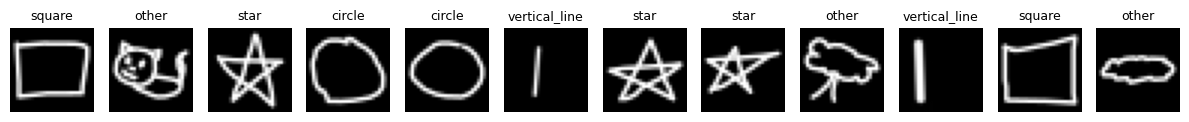

In [43]:
def show_grid(X, y, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(X[i,...,0], cmap="gray")
        plt.title(CLASS_NAMES[y[i]], fontsize=9)
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_grid(Xtr, ytr, n=12)


In [44]:
# predictions on validation set
proba = model.predict(Xva, verbose=0)
yhat  = proba.argmax(axis=1)

print(classification_report(yva, yhat, target_names=CLASS_NAMES, digits=3))

# confusion matrix (vanilla matplotlib)
cm = confusion_matrix(yva, yhat, labels=range(len(CLASS_NAMES)))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(CLASS_NAMES))); ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


NameError: name 'classification_report' is not defined

In [ ]:
def predict_with_reject(Xb, tau=0.6):
    proba = model.predict(Xb, verbose=0)
    maxp  = proba.max(axis=1)
    arg   = proba.argmax(axis=1)
    labels = np.where(maxp < tau, -1, arg)  # -1 = unknown
    return labels, maxp, proba

# sweep τ to see trade-off
taus = np.linspace(0.4, 0.9, 11)
accs = []
for t in taus:
    labels, _, _ = predict_with_reject(Xva, tau=t)
    # treat unknown as wrong for this simple score
    ok = (labels == yva)
    accs.append(ok.mean())

plt.figure(); plt.plot(taus, accs, marker="o")
plt.xlabel("tau (rejection threshold)"); plt.ylabel("val accuracy (unknown counted as wrong)")
plt.title("Pick a τ you like"); plt.show()


In [ ]:
# pick a few that weren't in TARGETS or OTHERS
UNSEEN = ["airplane","banana","bus","chair"]
unseen_batch = []
for c in UNSEEN:
    path = os.path.join(DATA_DIR, f"{c}.npy")
    if os.path.exists(path):
        arr = np.load(path)[:200].reshape(-1,28,28,1).astype("float32")/255.0
        unseen_batch.append(arr)
if unseen_batch:
    X_unseen = np.concatenate(unseen_batch, axis=0)
    labels, maxp, _ = predict_with_reject(X_unseen, tau=0.6)
    unknown_rate = (labels==-1).mean()
    print(f"Unknown rate on unseen classes: {unknown_rate:.2%} (want this fairly high)")

In [ ]:

def predict_one_live(img28, tau=0.6, mdl=model, classes=CLASS_NAMES):
    x = img28.astype("float32")
    if x.max() > 1.0:
        x = x / 255.0
    x = x[None, ..., None]
    proba = mdl.predict(x, verbose=0)[0]
    i = proba.argmax()
    return ("unknown", float(proba[i])) if proba[i] < tau else (classes[i], float(proba[i]))


# demo on a val sample
lbl, conf = predict_one_live((Xva[0,...,0]*255).astype("uint8"), tau=0.6)
lbl, conf, "true:", CLASS_NAMES[yva[0]]


('circle', 0.9997544884681702, 'true:', 'circle')

In [ ]:
# jitter the training images by ±1 pixel
def jitter_shift(x):
    dy = np.random.randint(-1, 2)
    dx = np.random.randint(-1, 2)
    return np.roll(np.roll(x, dy, axis=0), dx, axis=1)

aug_X = Xtr.copy()
mask = np.random.rand(len(aug_X)) < 0.5
aug_X[mask,...,0] = np.array([jitter_shift(im) for im in aug_X[mask,...,0]])

#history = model.fit(aug_X, ytr, validation_data=(Xva, yva), epochs=6, batch_size=32, callbacks=[es], verbose=1)


In [ ]:
CLASS_NAMES

In [45]:
model.save("shapes_tinycnn_keras_plus_vertical_line.h5")

/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
type(model)

In [47]:
#  Now go to terminal to make a js model
!tensorflowjs_converter --input_format=keras \
    shapes_tinycnn_keras_plus_vertical_line.h5 \
    web_model/